<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2025/blob/main/Week5_GA_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Colab v3.1 (Student)
## GA Optimization with Multi-term Fitness (CartPole)

### Goal
Make GA improvements **visible**:
- Best fitness should increase over generations
- Optimized controller should outperform baseline clearly

### What we optimize
- **k** : damping strength (velocity weight)

### Fitness (multi-dimensional, non-saturating)
We avoid the “all steps hit MAX” problem by using:

**fitness = steps − λx·x_range − λθ·mean(|θ|) − λu·switch_rate**

Where:
- steps: episode length (capped by MAX_STEPS)
- x_range: max(x) − min(x)  (cart amplitude)
- mean(|θ|): average pole deviation from upright
- switch_rate: fraction of steps where action flips (chattering)

This aligns with Week 4: *control quality is multi-dimensional*.


## Cell 1 — Install dependencies

In [2]:
!pip -q install gymnasium

## Cell 2 — Imports

In [3]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

np.random.seed(0)


## Cell 3 — Experiment settings
If your results still look too similar:
- Increase `SEEDS` (more seeds = more robust comparison)
- Increase penalty weights (λx, λθ, λu)


In [4]:
# ---- Core evaluation settings ----
MAX_STEPS = 300                 # keep moderate so steps are not always saturated
SEEDS = tuple(range(20))        # more seeds -> clearer average differences

# ---- Fitness weights (tune if needed) ----
lambda_x = 25.0                 # cart amplitude penalty weight
lambda_theta = 800.0            # pole deviation penalty weight
lambda_u = 120.0                # action switching (chattering) penalty weight

# Baseline k for comparison
k_baseline = 0.3


## Cell 4 — Controller (same structure as Week 4/5)
We keep MF shapes fixed and optimize only `k`.

In [5]:
def triangular_mf(x, a, b, c):
    x = np.asarray(x, dtype=float)
    left = (x - a) / (b - a + 1e-12)
    right = (c - x) / (c - b + 1e-12)
    return np.maximum(np.minimum(left, right), 0.0)

# Fixed MF params (signed)
theta_neg  = (-0.5, -0.2, 0.0)
theta_zero = (-0.15, 0.0, 0.15)
theta_pos  = (0.0, 0.2, 0.5)

tdot_neg  = (-4.0, -1.5, 0.0)
tdot_zero = (-0.8, 0.0, 0.8)
tdot_pos  = (0.0, 1.5, 4.0)

def fuzzify_signed(theta, theta_dot):
    mu_theta = {
        "N": float(triangular_mf(theta, *theta_neg)),
        "Z": float(triangular_mf(theta, *theta_zero)),
        "P": float(triangular_mf(theta, *theta_pos)),
    }
    mu_tdot = {
        "N": float(triangular_mf(theta_dot, *tdot_neg)),
        "Z": float(triangular_mf(theta_dot, *tdot_zero)),
        "P": float(triangular_mf(theta_dot, *tdot_pos)),
    }
    return mu_theta, mu_tdot

def signed_tendency(mu):
    return mu["P"] - mu["N"]  # Z is neutral

def policy(obs, k):
    theta = float(obs[2])
    theta_dot = float(obs[3])
    mu_theta, mu_tdot = fuzzify_signed(theta, theta_dot)
    score = signed_tendency(mu_theta) + k * signed_tendency(mu_tdot)
    return 1 if score >= 0 else 0


## Cell 5 — Episode evaluation (multi-term fitness)
We record:
- steps
- x_range (cart amplitude)
- mean(|θ|)
- switch_rate (action changes)

Then compute fitness:
fitness = steps − λx·x_range − λθ·mean(|θ|) − λu·switch_rate


In [6]:
def run_episode_metrics(k, seed=0):
    env = gym.make("CartPole-v1")
    obs, info = env.reset(seed=seed)
    env.action_space.seed(seed)

    steps = 0
    xs = [float(obs[0])]
    thetas = [abs(float(obs[2]))]
    switches = 0
    prev_action = None

    for _ in range(MAX_STEPS):
        action = policy(obs, k)
        if prev_action is not None and action != prev_action:
            switches += 1
        prev_action = action

        obs, reward, terminated, truncated, info = env.step(action)
        steps += 1
        xs.append(float(obs[0]))
        thetas.append(abs(float(obs[2])))

        if terminated or truncated:
            break

    env.close()

    x_range = max(xs) - min(xs)
    mean_abs_theta = float(np.mean(thetas))
    switch_rate = switches / max(1, steps)

    fit = steps - lambda_x * x_range - lambda_theta * mean_abs_theta - lambda_u * switch_rate
    return fit, steps, x_range, mean_abs_theta, switch_rate

def fitness_k(k):
    results = [run_episode_metrics(k, seed=s) for s in SEEDS]
    avg = lambda idx: float(np.mean([r[idx] for r in results]))
    return (
        avg(0),  # fitness
        avg(1),  # steps
        avg(2),  # x_range
        avg(3),  # mean_abs_theta
        avg(4),  # switch_rate
        results
    )


## Cell 6 — Baseline scan (manual tuning)
This shows why manual tuning is hard and where GA starts.

In [7]:
for k in [0.2, 0.6, 1.0, 1.6, 2.2]:
    f, st, xr, th, sw, _ = fitness_k(k)
    print(f"k={k:>4.1f} | fitness={f:>8.2f} | steps={st:>6.1f} | x_range={xr:>5.2f} | mean|θ|={th:>6.4f} | switch={sw:>5.3f}")


k= 0.2 | fitness=  234.52 | steps= 300.0 | x_range= 0.23 | mean|θ|=0.0066 | switch=0.455
k= 0.6 | fitness=  224.43 | steps= 300.0 | x_range= 0.16 | mean|θ|=0.0032 | switch=0.574
k= 1.0 | fitness=  212.63 | steps= 300.0 | x_range= 0.24 | mean|θ|=0.0036 | switch=0.654
k= 1.6 | fitness=  207.40 | steps= 300.0 | x_range= 0.34 | mean|θ|=0.0038 | switch=0.675
k= 2.2 | fitness=  205.35 | steps= 300.0 | x_range= 0.34 | mean|θ|=0.0039 | switch=0.691


## Cell 7 — GA implementation (real-valued GA)
- Gene: k
- Fitness: as defined above


In [8]:
def tournament_select(pop, fit_vals, size=3):
    idx = np.random.choice(len(pop), size=size, replace=False)
    return pop[idx[np.argmax([fit_vals[i] for i in idx])]]

def crossover(a, b, alpha=0.5):
    lo = min(a, b) - alpha * abs(a - b)
    hi = max(a, b) + alpha * abs(a - b)
    return float(np.random.uniform(lo, hi))

def mutate(x, sigma=0.25, kmin=0.0, kmax=3.0):
    return float(np.clip(x + np.random.normal(0, sigma), kmin, kmax))

def run_ga(pop_size=16, generations=12, kmin=0.0, kmax=3.0):
    pop = list(np.random.uniform(kmin, kmax, size=pop_size))
    hist_best, hist_mean = [], []
    best_k, best_fit = None, -1e18

    for g in range(generations):
        fits = []
        for k in pop:
            f, *_ = fitness_k(k)
            fits.append(f)

        g_best_i = int(np.argmax(fits))
        g_best_k = pop[g_best_i]
        g_best_fit = fits[g_best_i]
        g_mean = float(np.mean(fits))

        if g_best_fit > best_fit:
            best_fit, best_k = g_best_fit, g_best_k

        hist_best.append(g_best_fit)
        hist_mean.append(g_mean)

        print(f"Gen {g+1:02d}: best fitness={g_best_fit:8.2f} (k={g_best_k:5.3f}) | mean={g_mean:8.2f}")

        # elitism
        new_pop = [g_best_k]
        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, fits)
            p2 = tournament_select(pop, fits)
            child = crossover(p1, p2)
            child = mutate(child, sigma=0.25, kmin=kmin, kmax=kmax)
            new_pop.append(child)
        pop = new_pop

    return best_k, best_fit, hist_best, hist_mean


## Cell 8 — Run GA (this should show best fitness increasing)

In [9]:
best_k, best_fit, hist_best, hist_mean = run_ga()

print("\nOptimized k:", best_k)
print("Best fitness:", best_fit)


Gen 01: best fitness=  230.21 (k=0.213) | mean=  208.67
Gen 02: best fitness=  236.16 (k=0.194) | mean=  149.48
Gen 03: best fitness=  236.16 (k=0.194) | mean=  169.03
Gen 04: best fitness=  246.29 (k=0.177) | mean=  204.96
Gen 05: best fitness=  246.29 (k=0.177) | mean=   86.31
Gen 06: best fitness=  246.29 (k=0.177) | mean=  169.58
Gen 07: best fitness=  246.29 (k=0.177) | mean=  187.82
Gen 08: best fitness=  246.29 (k=0.177) | mean=  219.35
Gen 09: best fitness=  246.29 (k=0.177) | mean=  193.51
Gen 10: best fitness=  246.29 (k=0.177) | mean=  165.04
Gen 11: best fitness=  246.29 (k=0.177) | mean=  222.46
Gen 12: best fitness=  246.29 (k=0.177) | mean=  174.10

Optimized k: 0.177307143886221
Best fitness: 246.28975564605895


## Cell 9 — Plot GA progress

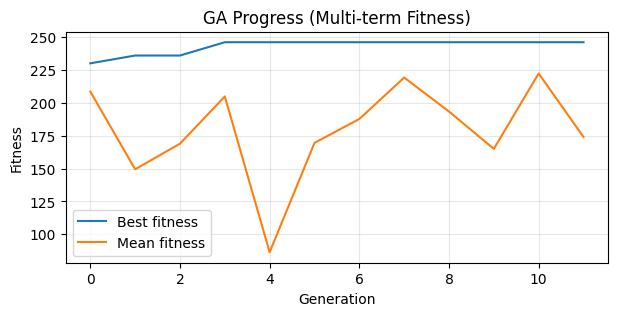

In [10]:
plt.figure(figsize=(7,3))
plt.plot(hist_best, label="Best fitness")
plt.plot(hist_mean, label="Mean fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("GA Progress (Multi-term Fitness)")
plt.show()


## Cell 10 — Baseline vs Optimized comparison (key reporting cell)

In [11]:
b = fitness_k(k_baseline)
o = fitness_k(best_k)

print("Baseline")
print(f"  k={k_baseline:.3f} | fitness={b[0]:.2f} | steps={b[1]:.1f} | x_range={b[2]:.4f} | mean|θ|={b[3]:.6f} | switch={b[4]:.4f}")

print("Optimized")
print(f"  k={best_k:.3f} | fitness={o[0]:.2f} | steps={o[1]:.1f} | x_range={o[2]:.4f} | mean|θ|={o[3]:.6f} | switch={o[4]:.4f}")


Baseline
  k=0.300 | fitness=212.98 | steps=300.0 | x_range=0.2110 | mean|θ|=0.003283 | switch=0.6593
Optimized
  k=0.177 | fitness=246.29 | steps=300.0 | x_range=0.1884 | mean|θ|=0.011299 | switch=0.3330


## Cell 11 — Video comparison parameter settings (same seed/same steps)

In [12]:
# --- Video comparison settings ---
VIDEO_SEED = 0        # same seed for both videos (change if you want)
VIDEO_STEPS = 120     # clip length for both videos (same steps)
VIDEO_FPS = 20        # mp4 fps

# Baseline/Optimized k (use the same ones shown in Cell10)
k_video_baseline = k_baseline
k_video_optimized = best_k

print("Video baseline k:", k_video_baseline)
print("Video optimized k:", k_video_optimized)
print("Video seed:", VIDEO_SEED, "Video steps:", VIDEO_STEPS)

Video baseline k: 0.3
Video optimized k: 0.177307143886221
Video seed: 0 Video steps: 120


## Cell 12 — MP4 generation function

In [13]:
import matplotlib.pyplot as plt
from matplotlib import animation
from google.colab import files

def record_mp4_for_k(k, seed, n_steps, filename, fps=20):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset(seed=seed)
    env.action_space.seed(seed)

    frames = []
    steps = 0

    for _ in range(n_steps):
        action = policy(obs, k)
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        steps += 1
        if terminated or truncated:
            break

    env.close()
    print(f"Recorded {steps} frames for k={k:.3f} → {filename}")

    fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(frames[0])

    def init():
        im.set_data(frames[0])
        return (im,)

    def animate_i(i):
        im.set_data(frames[i])
        return (im,)

    anim = animation.FuncAnimation(
        fig, animate_i, init_func=init,
        frames=len(frames), interval=50, blit=True
    )

    anim.save(filename, fps=fps)
    plt.close(fig)
    print("Saved:", filename)
    return steps

##Cell 13 — MP4 generation for "Baseline" and "Optimized"

In [14]:
baseline_mp4 = "week5_baseline.mp4"
optimized_mp4 = "week5_optimized.mp4"

steps_b = record_mp4_for_k(k_video_baseline, VIDEO_SEED, VIDEO_STEPS, baseline_mp4, fps=VIDEO_FPS)
steps_o = record_mp4_for_k(k_video_optimized, VIDEO_SEED, VIDEO_STEPS, optimized_mp4, fps=VIDEO_FPS)

print("\nVideo frames (baseline, optimized):", steps_b, steps_o)

# If one video is shorter, try a different VIDEO_SEED
if steps_b < VIDEO_STEPS or steps_o < VIDEO_STEPS:
    print("Note: One video ended early. Try changing VIDEO_SEED (e.g., 1, 2, 3...) for a fair visual comparison.")

Recorded 120 frames for k=0.300 → week5_baseline.mp4
Saved: week5_baseline.mp4
Recorded 120 frames for k=0.177 → week5_optimized.mp4
Saved: week5_optimized.mp4

Video frames (baseline, optimized): 120 120


##Cell 14 — MP4 Download

In [15]:
files.download(baseline_mp4)
files.download(optimized_mp4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## How to write the report (3–5 lines)
Write short answers referencing **Cell 10**:

- Baseline k and (fitness, steps, x_range, mean|θ|, switch)
- Optimized k and the same metrics
- Explain what improved (usually lower x_range / lower mean|θ| / lower switch)
- Connect to Week 4: step count alone was not enough; multi-dimensional fitness reveals improvement.
